# Card Detection

In [60]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

def display_image(image, title=None, cmap=None, max_size=(800, 800)):
    """
    Display an image using matplotlib after resizing it to a smaller size.

    Parameters:
    - image: The image to display.
    - title: The title of the image (optional).
    - cmap: The colormap to use for displaying the image (optional).
    - max_size: The maximum size (width, height) to resize the image to (default is (400, 400)).
    """
    # Resize the image to fit within the max_size while maintaining the aspect ratio
    h, w = image.shape[:2]
    scaling_factor = min(max_size[0] / w, max_size[1] / h)
    new_size = (int(w * scaling_factor), int(h * scaling_factor))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Convert color from BGR (OpenCV) to RGB (Matplotlib)
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(4, 4))  # Adjust the figsize to make the display smaller
    if title:
        plt.title(title)
    plt.imshow(resized_image, cmap=cmap)
    plt.axis('off')
    plt.show()

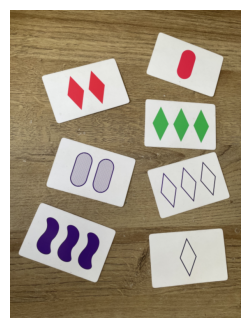

In [61]:
# Load the image using OpenCV
image = cv2.imread('./static/ex-2.png')
image = imutils.resize(image, width=500)

# Display the image
display_image(image=image)


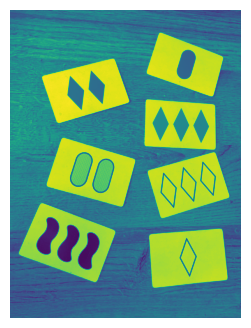

In [62]:
# Apply grey scale filter
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display_image(gray)


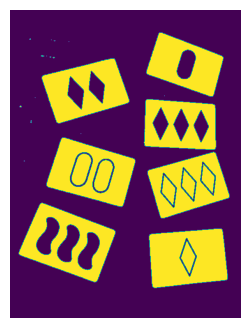

In [63]:
# Gaussian blur the image.
blur = cv2.GaussianBlur(gray, (3, 3), 0)

# Otsu's threshold
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

display_image(thresh)

In [78]:
def rotate_and_crop(image, rect):
    """
    Rotate the image around the center of the rectangle and crop it,
    ensuring the longer side is on the x-axis.

    Parameters:
    - image: The source image.
    - rect: The bounding rectangle (center, size, angle).

    Returns:
    - The rotated and cropped image.
    """
    center, size, angle = rect[0], rect[1], rect[2]
    width, height = size

    # Ensure the longer side is on the x-axis
    if width < height:
        angle += 90
        size = (height, width)

    size = tuple(map(int, size))

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    height, width = image.shape[:2]

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (width, height))

    # Crop the rotated rectangle
    cropped = cv2.getRectSubPix(rotated, size, center)

    return cropped


Contours detected: 7


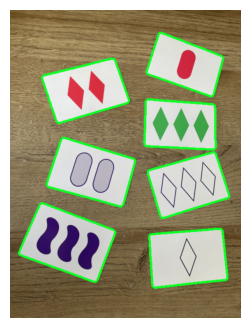

In [79]:
# Find contours and filter for cards using contour area
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the contours list. Depending on OpenCV version, this is a different 
# in the return list.
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

contours_image = image.copy()

# We don't want to capture the smaller shapes, only the cards. So set a 
# threshold here. 
# TODO: make this dynamic (ie, find contours and then choose threshold 
#       to filter out the cards)
threshold_min_area = 400
rectangles = []
for c in cnts:
    area = cv2.contourArea(c)
    if area > threshold_min_area:
        cv2.drawContours(contours_image, [c], 0, (36,255,12), 3)

        rect = cv2.minAreaRect(c)
        rectangles.append(rect)

print("Contours detected:", len(rectangles))

display_image(contours_image)

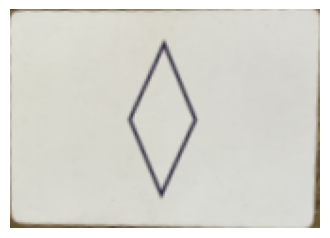

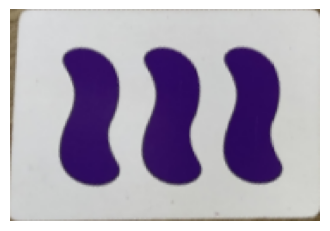

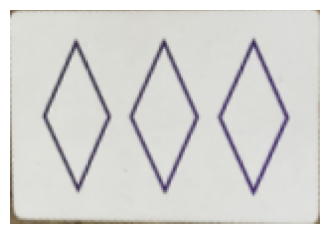

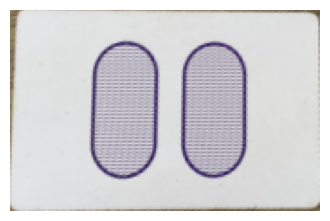

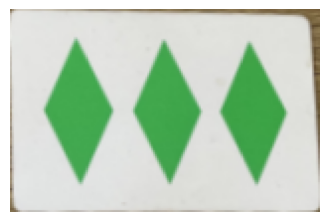

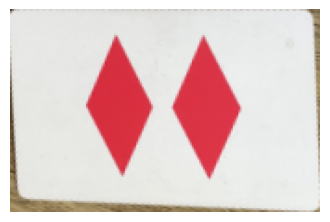

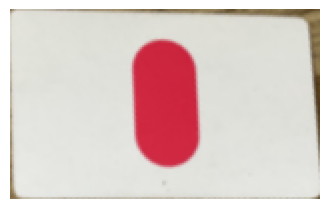

Number of rectangles: 7


In [87]:
import os

# Create a directory to save the extracted cards if it doesn't exist
# output_dir = 'extracted_cards'
# if not os.path.exists(output_dir):
#    os.makedirs(output_dir)

# Extract and display each card image
card_images = []
for i, rect in enumerate(rectangles):
    card_image = rotate_and_crop(image, rect)
    if card_image is not None:
        card_images.append(card_image)
        display_image(card_image)

        # Save the image to a file
        # output_path = os.path.join(output_dir, f'card_{i+1}.png')
        # cv2.imwrite(output_path, card_image)

# Print the number of rectangles
print(f"Number of rectangles: {len(rectangles)}")